项目根目录： C:\Users\admin\最终\Week2 Practice--RegressionModel
>>> 交叉验证结果


,Model,RMSE,MAE,R2
0,LinearRegression,55.585629,40.049225,0.543927
2,RandomForest,61.109239,39.616228,0.439458
1,DecisionTree,78.687132,50.348532,0.057035


>>> 最佳模型（LinearRegression）性能


,数据集,RMSE,MAE,R2
0,训练集,33.066767,22.419850,0.848514
1,测试集,64.185916,46.403286,0.433801


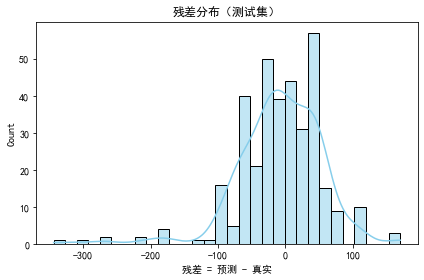

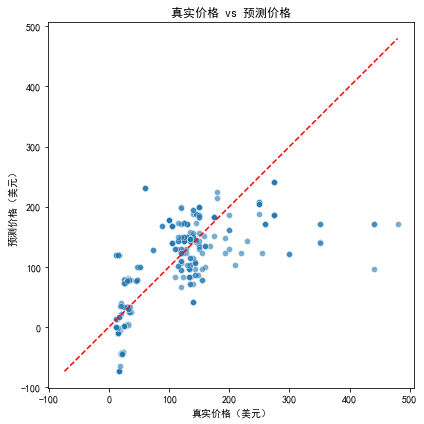

>>> 误差最大的 10 条记录


,City Name,Variety,true,pred,residual
1451,SAN FRANCISCO,HOWDEN TYPE,440.0,96.143909,-343.856091
1475,SAN FRANCISCO,PIE TYPE,480.0,171.232882,-308.767118
1509,SAN FRANCISCO,PIE TYPE,440.0,171.785000,-268.215000
1510,SAN FRANCISCO,PIE TYPE,440.0,171.785000,-268.215000
1478,SAN FRANCISCO,PIE TYPE,350.0,139.409157,-210.590843
1474,SAN FRANCISCO,PIE TYPE,350.0,140.368777,-209.631223
1477,SAN FRANCISCO,PIE TYPE,350.0,170.273261,-179.726739
1476,SAN FRANCISCO,PIE TYPE,350.0,171.232882,-178.767118
1471,SAN FRANCISCO,FAIRYTALE,300.0,121.759732,-178.240268
1472,SAN FRANCISCO,FAIRYTALE,300.0,121.759732,-178.240268


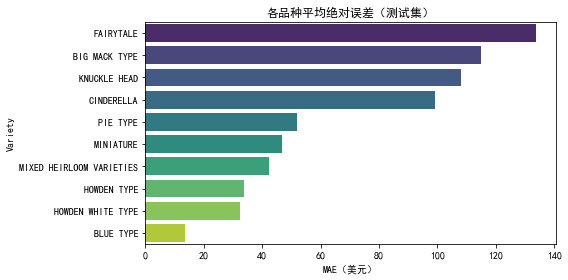

🎉 全部完成！表格 → C:\Users\admin\最终\Week2 Practice--RegressionModel\output\tables    图片 → C:\Users\admin\最终\Week2 Practice--RegressionModel\output\figs


In [8]:

import sys, subprocess, importlib, os
for pkg in ["numpy", "pandas", "matplotlib", "seaborn", "scikit-learn"]:
    try:
        importlib.import_module(pkg)
    except ModuleNotFoundError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 中文 & 负号
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 路径（零出错）
PROJECT_DIR = Path(r"C:\Users\admin\最终\Week2 Practice--RegressionModel")
DATA_PATH   = PROJECT_DIR / "data" / "US-pumpkins.csv"
FIG_DIR     = PROJECT_DIR / "output" / "figs"
TABLE_DIR   = PROJECT_DIR / "output" / "tables"
for d in (FIG_DIR, TABLE_DIR):
    d.mkdir(parents=True, exist_ok=True)

assert DATA_PATH.exists(), f"数据文件不存在：{DATA_PATH}"
print("项目根目录：", PROJECT_DIR)


df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y")
df["average_price"] = (df["Low Price"] + df["High Price"]) / 2
df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df = df.dropna(subset=["average_price"])

TARGET   = "average_price"
CAT_COLS = ["City Name", "Package", "Variety", "Origin", "Item Size"]
NUM_COLS = ["Year", "Month"]

X = df[CAT_COLS + NUM_COLS]
y = df[TARGET]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42)

ct = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS)],
    remainder="passthrough"
)

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree":     DecisionTreeRegressor(random_state=42),
    "RandomForest":     RandomForestRegressor(
                            n_estimators=100, random_state=42, n_jobs=2)
}

cv_res = []
for name, mdl in models.items():
    pipe = Pipeline([("prep", ct), ("model", mdl)])
    cv = cross_validate(
        pipe, X_train, y_train,
        cv=3,
        scoring=["neg_root_mean_squared_error", "neg_mean_absolute_error", "r2"],
        n_jobs=1, verbose=0)
    cv_res.append({
        "Model": name,
        "RMSE": -cv["test_neg_root_mean_squared_error"].mean(),
        "MAE":  -cv["test_neg_mean_absolute_error"].mean(),
        "R2":   cv["test_r2"].mean()
    })

cv_df = pd.DataFrame(cv_res).sort_values("RMSE")
cv_df.to_csv(TABLE_DIR / "cv_results.csv", index=False, encoding="utf-8-sig")
print(">>> 交叉验证结果")
display(cv_df)

best_name = cv_df.iloc[0]["Model"]
best_pipe = Pipeline([("prep", ct), ("model", models[best_name])])
best_pipe.fit(X_train, y_train)

y_pred_tr = best_pipe.predict(X_train)
y_pred_te = best_pipe.predict(X_test)

perf = pd.DataFrame({
    "数据集": ["训练集", "测试集"],
    "RMSE": [
        mean_squared_error(y_train, y_pred_tr, squared=False),
        mean_squared_error(y_test,  y_pred_te, squared=False)
    ],
    "MAE": [
        mean_absolute_error(y_train, y_pred_tr),
        mean_absolute_error(y_test,  y_pred_te)
    ],
    "R2": [
        r2_score(y_train, y_pred_tr),
        r2_score(y_test,  y_pred_te)
    ]
})
perf.to_csv(TABLE_DIR / "best_model_performance.csv", index=False, encoding="utf-8-sig")
print(">>> 最佳模型（{}）性能".format(best_name))
display(perf)

test_df = X_test.copy()
test_df["true"] = y_test
test_df["pred"] = y_pred_te
test_df["residual"] = test_df["pred"] - test_df["true"]
test_df["abs_err"]  = np.abs(test_df["residual"])
test_df.to_csv(TABLE_DIR / "test_predictions.csv", index=False, encoding="utf-8-sig")

# 5-1 残差分布
plt.figure(figsize=(6,4))
sns.histplot(test_df["residual"], kde=True, bins=30, color="skyblue")
plt.title("残差分布（测试集）")
plt.xlabel("残差 = 预测 - 真实")
plt.tight_layout()
plt.savefig(FIG_DIR / "residual_hist.png", dpi=300)
plt.show()

# 5-2 真实 vs 预测
plt.figure(figsize=(6,6))
sns.scatterplot(x="true", y="pred", data=test_df, alpha=0.6)
lims = [test_df[["true", "pred"]].min().min(), test_df[["true", "pred"]].max().max()]
plt.plot(lims, lims, 'r--')
plt.title("真实价格 vs 预测价格")
plt.xlabel("真实价格（美元）")
plt.ylabel("预测价格（美元）")
plt.tight_layout()
plt.savefig(FIG_DIR / "actual_vs_pred.png", dpi=300)
plt.show()

# 5-3 误差 TOP10
top10 = test_df.nlargest(10, "abs_err")[["City Name", "Variety", "true", "pred", "residual"]]
top10.to_csv(TABLE_DIR / "largest_errors_top10.csv", index=False, encoding="utf-8-sig")
print(">>> 误差最大的 10 条记录")
display(top10)

# 5-4 各品种平均误差
err_var = test_df.groupby("Variety")["abs_err"].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x="abs_err", y="Variety", data=err_var, palette="viridis")
plt.title("各品种平均绝对误差（测试集）")
plt.xlabel("MAE（美元）")
plt.tight_layout()
plt.savefig(FIG_DIR / "mae_by_variety.png", dpi=300)
plt.show()

print("🎉 全部完成！表格 →", TABLE_DIR, "   图片 →", FIG_DIR)